# Setup

In [1]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
from os import listdir
import torch.optim as optim
import matplotlib.pyplot as plt
from os.path import isfile, join
import torchvision.models as models
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [3]:
class dataset(Dataset):
    def __init__(self, image_root):
        self.image_root = image_root
        self.data_len = 0
        self.labels = listdir(image_root)
#         self.labels = ['Bad', 'Good']
        self.data = {}
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        for label in self.labels:
            for f in listdir('./DRIMDB/' + label):
                if isfile(join('./DRIMDB/' + label, f)):
                    self.data[join('./DRIMDB/', label, f)] = label
                    self.data_len += 1

    def __len__(self):
        return(self.data_len)
    
    def __getitem__(self, idx):
        img_path = list(self.data.keys())[idx]
        label = list(self.data.values())[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = self.transform(img)
        return(img, label)

In [4]:
def dataloader(dataset, batch_size, validation_split, shuffle_dataset):
    random_seed= 42

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    return(train_loader, val_loader)

In [ ]:
dataset = dataset(image_root="./DRIMDB")
train_loader, val_loader = dataloader(dataset = dataset, batch_size = 16, validation_split = 0.2, shuffle_dataset = True)

In [ ]:
def encode(label):
    rep = torch.zeros(3, dtype = torch.long).to(device)
    if label == 'Good':
        rep[0] = 1
    elif label == 'Bad':
        rep[1] = 1
    elif label == 'Outlier':
        rep[2] = 1
    return(rep)

In [ ]:
def encode_batch(batch):
    encode_tensor = None
    for i, label in enumerate(batch):
        rep = encode(label)
        if encode_tensor == None:
            encode_tensor_size = list(rep.size())
            encode_tensor_size.insert(0, len(batch))
            encode_tensor = torch.empty(*encode_tensor_size, dtype=rep.dtype, device=rep.device)
        encode_tensor[i, :] = rep
    return(encode_tensor)

# Sample visualization

In [ ]:
train_iter = iter(train_loader)
# train_iter = iter(val_loader)

In [ ]:
samples, labels = train_iter.next()

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

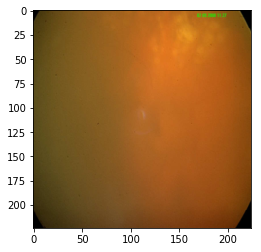

In [ ]:
trial_num = np.random.randint(0, 5)
imshow(samples[trial_num])

In [ ]:
labels[trial_num]

'Bad'

In [ ]:
labels

('Good',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Good',
 'Good',
 'Good',
 'Bad',
 'Bad',
 'Good',
 'Good',
 'Bad',
 'Bad')

# Model

In [ ]:
cnn = torchvision.models.alexnet(pretrained = True).to(device)

In [ ]:
for param in cnn.parameters():
    param.requires_grad = False

In [ ]:
cnn.classifier[-1] = nn.Linear(in_features = 4096, out_features = 3, bias = True)

In [ ]:
cnn.to(device)

In [ ]:
for param in cnn.parameters():
    if param.requires_grad:
        print(param.shape)

# Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optm = optim.Adam(cnn.parameters(), lr = 0.01)

In [ ]:
for i in range(10):
            
    loss_b = []
    acc_b = []
    for data in iter(train_loader):
        
        images, labels = data
        images = images.to(device)
        OH_labels = encode_batch(labels)
        pred = cnn.forward(images)
        
        cnn.eval()
        acc = accuracy_score(torch.max(pred, 1)[1].cpu(), torch.max(OH_labels, 1)[1].cpu())
        acc_b.append(acc)
        
        cnn.train()
        loss = loss_fn(pred, torch.max(OH_labels, 1)[1])
        loss_b.append(loss.item())
        optm.zero_grad()
        loss.backward()
        optm.step()
        
        del images, labels, OH_labels, pred
        torch.cuda.empty_cache()
    print("Loss at epoch ", i, "is ", loss.item())

In [ ]:
plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
plt.ylabel('loss')
plt.plot(loss_b)

plt.subplot(1, 2, 2)
plt.plot(acc_b)

In [ ]:
acc_b

In [ ]:
loss_b

In [ ]:
total, correct = 0, 0
for data in trial_loader:
    inputs, labels = data
    OH_labels = encode_batch(labels)
    inputs = inputs.to(device)
    outputs = cnn(inputs)
    pred = torch.max(outputs, 1)[1]
    total += len(labels)
#     print(pred)
#     print(torch.max(labels[0].data, 1)[1])
    correct += (pred == torch.max(OH_labels, 1)[1]).sum().item()
#     print(correct)

print(100 * correct / total)

In [ ]:
trial_num = np.random.randint(0, 16)
print(cnn.forward(samples[trial_num].unsqueeze(0).to(device)), labels[trial_num])